In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

In [2]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

In [3]:
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

In [4]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

async def answer_tool(state: AgentState):
    # Assumes the final answer is in state["prediction"]["args"][0]
    answer = state["prediction"]["args"][0] if state["prediction"]["args"] else "No answer provided."
    return f"Final Answer: {answer}"


In [5]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [6]:
!pip install langchain_together --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq

async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}

In [8]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

prompt = """
Imagine you are a robot browsing the web, just like humans. You can ONLY perform ONE specific action at a time from the following strict list of allowed actions:

1. Click [Numerical_Label] 
2. Type [Numerical_Label]; [Content]
3. Scroll [Numerical_Label or WINDOW]; [up or down]
4. Wait
5. GoBack
6. Google
7. ANSWER [content] (this is not a tool you sholud start with ANSWER and give the answer)

Human Request: {input}

Current Page Elements: {bbox_descriptions}

For each iteration, you will:
1. Receive an Observation with a screenshot showing numbered labels in the TOP LEFT corners of web elements.
2. Think carefully about the SINGLE next action needed.
3. Execute ONLY ONE action in the exact format shown above.

### STRICT RULES:
- Execute only ONE action per turn.
- Use ONLY the actions listed above—no exceptions.
- Always verify the numerical label before acting.
- Avoid unnecessary interactions (login/signup/ads).
- Stay focused on the given task.
- Never attempt actions outside the defined list.
- **If you execute a step and the browser state does not change, pause, re-evaluate, and select a valid alternative action after careful thought.**
- **If you see a popup, close it immediately unless it appears to be important.**
- **If you see a CAPTCHA, follow these steps:**
  1. Click on the "Solve" button.
  2. Select the required grid images correctly.
  3. Once all required selections are made, click on "Done."
  4. Submit the CAPTCHA and ensure it clears before proceeding.
  5. If CAPTCHA solving is not possible, use GoBack or Google to find another path.
- **After any page change, slow down, re-assess where you are, and determine the next optimal step to reach your goal efficiently.**
- **Once you believe you have reached your destination, review the code or relevant information on the page and answer the user's query directly.**

Your response must ALWAYS follow this exact format:
Thought: {{Brief analysis of current situation}}
Action: {{ONE action from the allowed list in exact format}}

Previous Steps: {scratchpad}

### REMEMBER:
- You are limited to ONLY these specific actions—no additional capabilities or variations are allowed.
- Always think critically before taking any action.
"""

# Convert the prompt string to a ChatPromptTemplate
prompt_template = ChatPromptTemplate.from_messages([
    ("system", prompt)
])

completion = ChatGroq(
    model="llama-3.2-90b-vision-preview",
    max_tokens=1024,
)
# Update the agent chain to include image data
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions 
    | prompt_template 
    | completion 
    | StrOutputParser() 
    | parse
)


In [9]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [10]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")

# --- Add the new ANSWER node ---
graph_builder.add_node("ANSWER", RunnableLambda(answer_tool) | (lambda observation: {"observation": observation}))
graph_builder.add_edge("ANSWER", END)

def select_tool(state: AgentState):
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return "ANSWER"  # Route to the ANSWER node instead of ending immediately
    if action == "retry":
        return "agent"
    return action

graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

In [11]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=[
            "--disable-blink-features=AutomationControlled",  # Hides automation flag
            "--disable-infobars",                             # Removes the 'Chrome is being controlled...' message
            "--start-maximized",                              # Start maximized to mimic user behavior
        ])
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['7', 'founders of Tesla']
2. Click: ['28']
3. Google: None
4. Type: ['10', 'founders of Tesla']
5. Type: ['6', 'founders of Tesla']
6. ANSWER: ['The founders of Tesla are Martin Eberhard, Marc Tarpenning, Elon Musk, Nagesh Saldi, and Vaibhav Taneja']


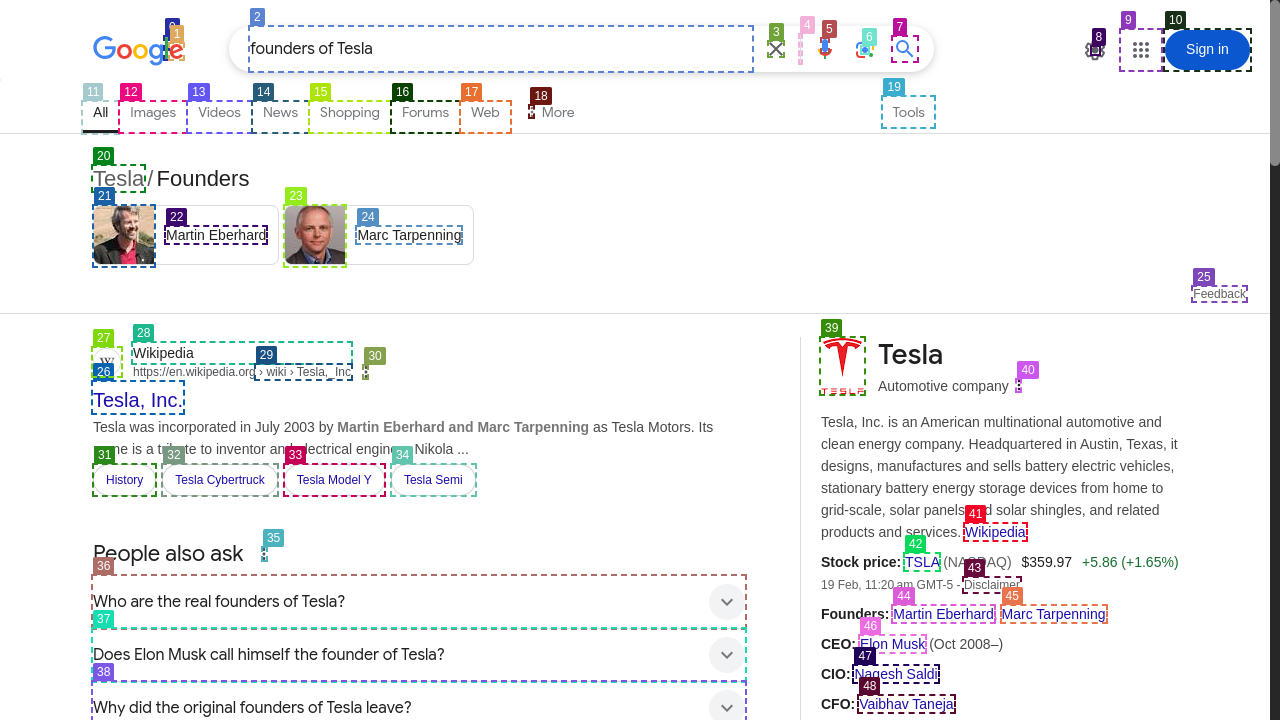

Final response: The founders of Tesla are Martin Eberhard, Marc Tarpenning, Elon Musk, Nagesh Saldi, and Vaibhav Taneja


In [12]:
res = await call_agent(
    "Who is the founders of Tesla",
    page,
)
print(f"Final response: {res}")